# Thermal circuit and state-space representation for a cubic Building
### Authors: Fabian Rechsteiner, Michael Wäspe

**Objectives:**
- Analyse a cubic building with 1 wall, 2 walls with a window and 3 adiabatic walls.
- Model the heat transfer in the building by a thermal circuit.
- Obtain the mathematical model as a system of Differential Algebraic Equations (DAE) from the thermal circuit.
- Transfrom the system of DAE into state-space representation.
- Find the steady-state solution.
- Simulate by using Euler methods for numerical integration..

# Visualization of Model
## Model

<div>
<img src="./figures_project/Building_Front.png" width="500"/>
<img src="./figures_project/Building_open.png" width="513"/>
</div>

> Figure 1. Simple Building with 3 walls considered as not perfectly isolated. The adiabatic walls are shown in red. One wall is missing in the illustration on the left and is intended to serve as a sectional model.

## Distances
<div>
<img src="./figures_project/Building_measured.png" width="600"/>
</div>

> Figure 2. Dimensioned representation of the cubic building model.

## Model Schematic
<div>
<img src="./figures_project/ThermalModel.png" width="1000"/>
</div>

> Figure 3. Cubic Building Model represented as a thermal model.

## Imports
Imports of all libraries that are needed.

In [1]:
# For High Resolution Screens
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## Physical Properties

### Thermo-physical properties and Dimension
#### General

In [2]:
# Properties Building
d_ins    = 0.1   #[m]
d_conc   = 0.2   #[m]
d_window = 0.04  #[m]
w_room   = 4     #[m]
w_window = 1.5   #[m]

# Properties Air
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)

#### Wall without window

In [3]:
# Properties wall without window
concrete_wow = {'Conductivity': 1.400,
                'Density': 2300.0,              # kg/m³
                'Specific heat': 880,           # J/(kg·K)
                'Width': d_conc,
                'Surface': w_room**2}

insulation_wow = {'Conductivity': 0.027,
                  'Density': 55.0,              # kg/m³
                  'Specific heat': 1210,        # J/(kg·K)
                  'Width': d_ins,
                  'Surface': w_room**2}
             
wall_wow = pd.DataFrame.from_dict({'Layer_out': concrete_wow,
                                   'Layer_in': insulation_wow},
                                   orient='index')          

# Print Data Frames
print('Properties of the wall without window:')
display(wall_wow)

Properties of the wall without window:


,Conductivity,Density,Specific heat,Width,Surface
Layer_out,1.400,2300.0,880,0.2,16
Layer_in,0.027,55.0,1210,0.1,16


#### Wall with window

In [4]:
# Properties wall without window
concrete_ww = {'Conductivity': 1.400,
               'Density': 2300.0,              # kg/m³
               'Specific heat': 880,           # J/(kg·K)
               'Width': d_conc,
               'Surface': w_room**2-w_window**2}

insulation_ww = {'Conductivity': 0.027,
                  'Density': 55.0,              # kg/m³
                  'Specific heat': 1210,        # J/(kg·K)
                  'Width': d_ins,
                  'Surface': w_room**2-w_window**2}

glass_ww = {'Conductivity': 1.4,
            'Density': 2500,
            'Specific heat': 1210,
            'Width': d_window,
            'Surface': w_window**2}
             
wall_ww = pd.DataFrame.from_dict({'Layer_out': concrete_ww,
                                  'Layer_in': insulation_ww,
                                  'Window': glass_ww},
                                  orient='index')          

# Print Data Frames
print('Properties of the wall with window:')
display(wall_ww)

Properties of the wall with window:


,Conductivity,Density,Specific heat,Width,Surface
Layer_out,1.400,2300.0,880,0.20,13.75
Layer_in,0.027,55.0,1210,0.10,13.75
Window,1.400,2500.0,1210,0.04,2.25


### Radiation Properties

The [radiative properties](https://en.wikipedia.org/wiki/Emissivity#Absorptivity) of the surfaces are:
- long wave [emmisivity](https://www.engineeringtoolbox.com/emissivity-coefficients-d_447.html) of concrete (between normal and rough) and glass pyrex;
- short wave [absortivity of solar radiation](https://www.engineeringtoolbox.com/solar-radiation-absorbed-materials-d_1568.html) of white smooth surfaces;
- short wave [transmittance](https://www.engineeringtoolbox.com/optical-properties-glazing-materials-d_1355.html) of window glass (thickness of 4 mm);
- short wave [absortivity and transmittance](https://energieplus-lesite.be/techniques/enveloppe7/composants-de-l-enveloppe/vitrages/vitrage-permettant-le-controle-solaire/) of reflective blue window glass.

In [5]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

# Stefan-Bolzmann constant
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print('Stefan-Bolzmann constant: ',f'σ = {σ} W/(m²⋅K⁴)')

Stefan-Bolzmann constant:  σ = 5.67e-08 W/(m²⋅K⁴)


### Convection coefficients

Conventional values for the [convection coeficients](https://energieplus-lesite.be/theories/enveloppe9/echanges-chaleur-parois/resistance-thermique-d-echange-superficiel/) for indoor and outdoor convection in W/(m²⋅K) are:

In [6]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
print('Convection Coefficients:')
display(h)

Convection Coefficients:


,in,out
h,8.0,25


### Thermal coductances
#### Conduction
The conductances 1, 2, 3, and 4 of the thermal circuit from Figure 3 model the heat transfer by [conduction](https://en.m.wikipedia.org/wiki/Thermal_conduction). Conduction conductances, in W/K, are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

In [7]:
# conduction
G_cond_wow = wall_wow['Conductivity'] / wall_wow['Width'] * wall_wow['Surface']
G_cond_ww = wall_ww['Conductivity'] / wall_ww['Width'] * wall_ww['Surface']
print('Conductance of the wall without window:')
display(pd.DataFrame(G_cond_wow, columns={'Conductance'}))
print('Conductance of the wall with window:')
display(pd.DataFrame(G_cond_ww, columns={'Conductance'}))

Conductance of the wall without window:


,Conductance
Layer_out,112.00
Layer_in,4.32


Conductance of the wall with window:


,Conductance
Layer_out,96.2500
Layer_in,3.7125
Window,78.7500


#### Convection
The conductances 0, 6 and 7 model the heat transfer by [convection](https://en.m.wikipedia.org/wiki/Convection_(heat_transfer). Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m².

>Table 1. Surface thermal resistances [Dal Zotto et al. 2014, p. 251]

| Type of wall | Indoor surface |Outdoor surface|
|--------------|:--------------:|:-------------:|
|              | $h_i$,W/(m²·K) | $h_o$,W/(m²·K)|
|*Vertical* (tilt > 60°)|    7.7| 25 |
|*Horizontal* (tilt < 60°)|     |    |
|- Upward heat flow   |       10| 25 |
|- Downward heat flow |      5.9| 25 |

In [8]:
# convection
G_conv_wow = h * wall_wow['Surface']['Layer_out']   # wall without window
G_conv_ww  = h * wall_ww['Surface']['Layer_in']   # wall
G_conv_g    = h * wall_ww['Surface']['Window']     # glass

print('Convection Coefficients of wall without window:')
display(G_conv_wow)
print('Convection Coefficients of wall with window:')
display(G_conv_ww)
print('Convection Coefficients of window:')
display(G_conv_g)

Convection Coefficients of wall without window:


,in,out
h,128.0,400


Convection Coefficients of wall with window:


,in,out
h,110.0,343.75


Convection Coefficients of window:


,in,out
h,18.0,56.25


#### Long wave radiation
##### View factors inside the building

The view factor $F_{i,j}$ is defined as *the proportion of radiation leaving surface $i$ that is intercepted by surface $j$*. A simplified model is used to determine the viewfactors.

The view factors are defined by:
$$\begin{cases}
F_{i,j} = \frac{S_j}{S_T -S_i}\\ 
F_{i,i} = 0
\end{cases}$$

where $S_{T} = \sum_{j=0}^{n-1} S_j$, i.e. the surface $S_i$ is not included in the total surface $S_{T,i} = S_T - S_i$. 

<div>
<img src="./figures_project/viewfactorsSimplifiedRepresentation.png" width="600"/>
</div>

> Figure 4. Simplified representation of the relevant view factors of the cubic building model.


In [9]:
# Total surface
S_t = wall_wow['Surface']['Layer_in']*6
# Viewfactors (simplified)
S_1_3 = wall_ww['Surface']['Layer_in']  / (S_t - wall_ww['Surface']['Layer_in'] - wall_ww['Surface']['Window'])  # (#3 / (total - #1 - #2)
S_1_4 = wall_ww['Surface']['Window']    / (S_t - wall_ww['Surface']['Layer_in'] - wall_ww['Surface']['Window'])    # (#4 / (total - #1 - #2)
S_1_5 = wall_wow['Surface']['Layer_in'] / (S_t - wall_ww['Surface']['Layer_in'] - wall_ww['Surface']['Window']) # (#5 / (total - #1 - #2)
S_2_3 = wall_ww['Surface']['Layer_in']  / (S_t - wall_ww['Surface']['Window']   - wall_ww['Surface']['Layer_in'])  # (#3 / (total - #2 - #1)
S_2_4 = wall_ww['Surface']['Window']    / (S_t - wall_ww['Surface']['Window']   - wall_ww['Surface']['Layer_in'])    # (#4 / (total - #2 - #1)
S_2_5 = wall_wow['Surface']['Layer_in'] / (S_t - wall_ww['Surface']['Window']   - wall_ww['Surface']['Layer_in']) # (#5 / (total - #2 - #1)
S_3_5 = wall_wow['Surface']['Layer_in'] / (S_t - wall_ww['Surface']['Layer_in'] - wall_ww['Surface']['Window']) # (#5 / (total - #3 - #4)
S_4_5 = wall_wow['Surface']['Layer_in'] / (S_t - wall_ww['Surface']['Window']   - wall_ww['Surface']['Layer_in']) # (#5 / (total - #4 - #3)

##### Thermal network for long wave radiation

The long-wave heat exchange between surfaces may be modelled by using the concept of [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) and then linearizing the radiative heat exchange. 

![LW_rad_excg](./figures/03_LW_rad_excg.svg)
> Figure 5. Radiative long-wave heat exchange between two surfaces: a) modeled by [emmitance](https://en.m.wikipedia.org/wiki/Radiant_exitance) (source) and [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) (nodes); b) modeled by linearization of emmitance (temperature sources) and radiosity (temperature nodes).

After linearization, the conductances, in W/K, for radiative heat exchange are:

$$G_{1} = 4 \sigma \bar{T}^3 \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2} = 4 \sigma \bar{T}^3 F_{1,2} S_1 = 4 \sigma \bar{T}^3 F_{2,1} S_2$$

$$G_{2} = 4 \sigma \bar{T}^3 \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

<div>
<img src="./figures_project/ThermalModel_radiation.png" width="500"/>
</div>

> Figure 3. Model of long wave radiation in cubic building model

In [10]:
# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW24 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall_ww['Surface']['Layer_in']
GLW25 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall_ww['Surface']['Window']
GLW26 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall_ww['Surface']['Layer_in']
GLW27 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall_ww['Surface']['Window']
GLW28 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall_wow['Surface']['Layer_in']
GLW29 = 4 * σ * Tm**3 * S_1_3 * wall_ww['Surface']['Layer_in']
GLW30 = 4 * σ * Tm**3 * S_1_4 * wall_ww['Surface']['Layer_in']
GLW31 = 4 * σ * Tm**3 * S_1_5 * wall_ww['Surface']['Layer_in']
GLW32 = 4 * σ * Tm**3 * S_2_3 * wall_ww['Surface']['Window']
GLW33 = 4 * σ * Tm**3 * S_2_4 * wall_ww['Surface']['Window']
GLW34 = 4 * σ * Tm**3 * S_2_5 * wall_ww['Surface']['Window']
GLW35 = 4 * σ * Tm**3 * S_3_5 * wall_ww['Surface']['Layer_in']
GLW36 = 4 * σ * Tm**3 * S_4_5 * wall_ww['Surface']['Window']

#### Conductances in series and/or parallel
If conductances are connected to temperature nodes which have no capacity and/or flow rate source, then the conductances can be considered in [series or parallel](https://en.m.wikipedia.org/wiki/Series_and_parallel_circuits) (depending on the connection). Let's consider, for example, the outdoor side of the glass window (Figure 3): the outdoor convection conductance and the conduction conductance (corresponding to half of the width of the glass) are in series:

$$ G_{gs} = \frac{1}{1/G_{g,cv.out } + 1/(2 G_{g,cd})} =  
\frac{1}{\frac{1}{h_{out} S_g} + \frac{w / 2}{\lambda S_g}}
$$

In [11]:
# glass: convection outdoor & conduction
G_conv_cond_g = float(1 / (1 / G_conv_g['out'] + 1 / (G_cond_ww['Window']/2)))

### Thermal capacities
#### Walls
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall, in J/kg, are:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the mass of the wall, kg;
- $c_w$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity), J/(kg⋅K);
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density), kg/m³;
- $w_w$ - width of the wall, m;
- $S_w$ - surface area of the wall, m².

In [12]:
C_wow = wall_wow['Density'] * wall_wow['Specific heat'] * wall_wow['Surface'] * wall_wow['Width']
C_ww  = wall_ww['Density'] * wall_ww['Specific heat'] * wall_ww['Surface'] * wall_ww['Width']

#### Air
Similarly, the thermal capacity of the air, in J/kg, is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, kg;
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K);
- $V_a$ - volume of the air in the thermal zone, m³.

In [13]:
Va = w_room**3 # m³, volume of air
C_air = air['Density'] * air['Specific heat'] * Va

### Heat flow rate sources
The [heat flow rate sources](https://en.m.wikipedia.org/wiki/Current_source#Background) model flow rates which vary idependently of what happens in the themal circuit. They are inputs of the physical model. Generally, the heat flow rate sources are:
- solar radiation absorbed by the walls;
- internal auxiliary sources.

#### Solar radiation absorbed by the walls

The [direct](https://en.m.wikipedia.org/wiki/Direct_insolation), diffuse and reflected components of the [solar radiation](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface can be estimated from weather data by using the function `sol_rad_tilt_surf` from the module `dm4bem` (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

##### External wall

The radiation absorbed by the outdoor surface of the wall is:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:
- $\alpha_{w,SW}$ is the [absorptance](https://en.m.wikipedia.org/wiki/Absorptance) of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total [solar irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on the wall, W/m².

##### Internal walls

The total shortwave incident irradiance on the wall $i$, $E_i$, may be estimated as a function of the direct solar irradiance incident on the surface of the walls, $E_{i}^{o}$:

$$S_i E_i = S_i E_{i}^{o} + \sum_{j=1}^{n} F_{j,i} S_j \rho_j E_j$$

where:
- $S_i$ is the area of the surface of the wall $i$, m²;
- $E_i$ - total irradiance received directly and by multiple reflections on surface $i$, W/m²;
- $E_{i}^{o}$ - irradiance received directly from the sun on surface $i$, W/m²;
- $F_{j, i}$ - [view factor](https://en.m.wikipedia.org/wiki/View_factor) between surface $j$ and surface $i$, $0 ⩽ F_{j,i} ⩽ 1$;
- $\rho_j$ - [reflectance](https://en.m.wikipedia.org/wiki/Reflectance) of surface $j$, $0 ⩽ \rho_j ⩽ 1$.


By taking into account the [reciprocity](https://en.m.wikipedia.org/wiki/View_factor#Reciprocity) of the view factors: $S_i F_{i,j} = S_j F_{j,i}$, the set of previous equation becomes:

$$
\begin{bmatrix}
1 - \rho_1 F_{1,1} & - \rho_2 F_{1,2}     & ...  & - \rho_n F_{1,n}\\ 
- \rho_1 F_{2,1}   & 1 - \rho_2 F_{2,2}  & ...  & - \rho_n F_{2,n} \\ 
...                         & ...                            & ...  & ... \\ 
- \rho_1 F_{n,1}  & - \rho_2 F_{n,1}      & ... & 1 - \rho_n F_{n,n}
\end{bmatrix} \begin{bmatrix}
E_1\\ 
E_2\\ 
...\\ 
E_n
\end{bmatrix} = \begin{bmatrix}
E_{1}^{o}\\ 
E_{2}^{o}\\ 
...\\ 
E_{n}^{o}
\end{bmatrix}
$$

or

$$(I - \rho \circ F) E = E^o$$

The unknown total [irradiances](https://en.m.wikipedia.org/wiki/Irradiance) on walls, in W/m², are then

$$ E = (I - \rho \circ F)^{-1} E^o$$

where:

- the symbol $\circ$ represents the [Hadamard (or element-wise) product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices));

$I =\begin{bmatrix}
1 & 0 & ... & 0 \\ 
0 & 1 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & 1 
\end{bmatrix}, $ is the [identity matrix](https://en.m.wikipedia.org/wiki/Identity_matrix);

$\rho = \begin{bmatrix}
\rho_1\\ 
\rho_2\\ 
...\\ 
\rho_n
\end{bmatrix}$ - vector of [reflectances](https://en.m.wikipedia.org/wiki/Reflectance), $0 \le \rho_{i,j} \le 1$;

$F = \begin{bmatrix}
F_{1,1} & F_{1,2} & ... & F_{1,n}\\ 
F_{2,1} & F_{2,2} & ... & F_{2,n} \\ 
... & ... & ... & ...\\ 
F_{n,1} & F_{n,2} & ... & F_{n,n}
\end{bmatrix}$ - matrix of [view factors](https://en.m.wikipedia.org/wiki/View_factor), $0 \le F_{i,j} \le 1$;

$E^o = \begin{bmatrix}
E_{1}^{o}\\ 
E_{2}^{o}\\ 
...\\ 
E_{n}^{o}
\end{bmatrix}$ - vector of [direct solar irradiances](https://en.m.wikipedia.org/wiki/Solar_irradiance), W/m²;

$E = \begin{bmatrix}
E_1\\ 
E_2\\ 
...\\ 
E_n
\end{bmatrix}$ - vector of unknown total irradiances, W/m².


The radiative short wave (i.e. solar) heat flow rate on each surface is:

$$ \Phi = S E $$

where:

$\Phi = \begin{bmatrix}
\Phi_1\\ 
\Phi_2\\ 
...\\ 
\Phi_n
\end{bmatrix}$ - vector of total heat flow rates due to solar radiation, W; 

$S =\begin{bmatrix}
S_1 & 0 & ... & 0 \\ 
0 & S_2 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & S_n 
\end{bmatrix}$ - matrix of surface areas of walls $i$, m².

## System of algebraic-differential equations (DAE)

The analysis of a thermal circuit, or the direct problem ([Ghiaus 2022](https://hal.archives-ouvertes.fr/hal-03484064/document)), means to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, i.e. to solve for $\theta$ and $q$ the system of [Differential-Algebraic Equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (Figures 3 and 4):

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ is the temperature vector of size $n_\theta$ equal to the number of nodes;
- $q$ - heat flow vector of size $n_q$ equal to the number of branches;
- $A$ - [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. It shows how the temperature nodes are connected by oriented branches of heat flows:
    - if flow *m* enters into node *n*, then the element (*m, n*) of the matrix $A$ is 1, i.e., $A_{m,n} = 1$;
    - if flow *m* exits from node *n*, then the element (*m, n*) of the matrix $A$ is -1, i.e., $A_{m,n} = -1$, ; 
    - if flow *m* is not connected to node *n*, then the element (*m, n*) of the matrix $A$ is 0, i.e., $A_{m,n} = 0$.

- $G$ - conductance diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

- $C$ - capacity diagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- $b$ - temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.

- $f$ - heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

The resolution is first done for temperatures, $\theta$, by solving the equation
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the equation
$$q = G (-A \theta + b)$$


### A: incidence matrix

The [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) is:

$A_{kl} = \begin{cases}\phantom{-}
0 & \text{if branch } q_k \text{ is not connected to node }  \theta_l \\ 
+1 & \text{if branch } q_k \text{ enters into node }  \theta_l\\ 
-1 & \text{if branch } q_k \text{ gets out of node }  \theta_l 
\end{cases}$

In [14]:
# A --> 37x25
#              Θ0    Θ1    Θ2    Θ3    Θ4    Θ5    Θ6    Θ7    Θ8    Θ9    Θ10   Θ11   Θ12   Θ13   Θ14   Θ15   Θ16   Θ17   Θ18   Θ19   Θ20   Θ21   Θ22   Θ23   Θ24 
A = np.array([[ 1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q0
              [-1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q1
              [ 0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q2
              [ 0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q3
              [ 0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q4
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q5
              [ 0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q6
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q7
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q8
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q9
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q10
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q11
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q12
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q13
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q14
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q15
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q16
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q17
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q18
              [ 0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q19
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q20
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q21
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q22
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q23
              [ 0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0 ],  # q24
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0 ],  # q25
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0 ],  # q26
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0 ],  # q27
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1 ],  # q28
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  1  ,  0  ,  0 ],  # q29
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  1  ,  0 ],  # q30
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  1 ],  # q31
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  1 ],  # q32
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  1  ,  0 ],  # q33
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0 ],  # q34
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  1 ],  # q35
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1 ]]) # q36

### G: conductance matrix


In [15]:
# G --> 37x37
G = np.zeros((37, 37))
# Wall with window
G[0,0]   = G_conv_ww['out']
G[1,1]   = G_cond_ww['Layer_out']/2
G[2,2]   = G_cond_ww['Layer_out']/2
G[3,3]   = G_cond_ww['Layer_in']/2
G[4,4]   = G_cond_ww['Layer_in']/2
# Window
G[5,5]   = G_conv_cond_g  # Convection and conduction of window
G[6,6]   = G_cond_ww['Window']/2
# Wall with window
G[7,7]   = G_conv_ww['out']
G[8,8]   = G_cond_ww['Layer_out']/2
G[9,9]   = G_cond_ww['Layer_out']/2
G[10,10] = G_cond_ww['Layer_in']/2
G[11,11] = G_cond_ww['Layer_in']/2
# Window
G[12,12] = G_conv_cond_g  # Convection and conduction of window
G[13,13] = G_cond_ww['Window']/2
# Wall without window
G[14,14] = G_conv_wow['out']
G[15,15] = G_cond_wow['Layer_out']/2
G[16,16] = G_cond_wow['Layer_out']/2
G[17,17] = G_cond_wow['Layer_in']/2
G[18,18] = G_cond_wow['Layer_in']/2
# Convections to inside air
G[19,19] = G_conv_ww['in']
G[20,20] = G_conv_g['in']
G[21,21] = G_conv_ww['in']
G[22,22] = G_conv_g['in']
G[23,23] = G_conv_wow['in']
# Long wave radiation
G[24,24] = GLW24
G[25,25] = GLW25
G[26,26] = GLW26
G[27,27] = GLW27
G[28,28] = GLW28
G[29,29] = GLW29
G[30,30] = GLW30
G[31,31] = GLW31
G[32,32] = GLW32
G[33,33] = GLW33
G[34,34] = GLW34
G[35,35] = GLW35
G[36,36] = GLW36

### C: capacity matrix


In [16]:
# C --> 25x25
C = np.zeros((25, 25))
# Wall with window
C[1,1] = C_ww['Layer_out']
C[3,3] = C_ww['Layer_in']
# Window
C[5,5] = C_ww['Window']
# Wall with window
C[8,8] = C_ww['Layer_out']
C[10,10] = C_ww['Layer_in']
# Window
C[12,12] = C_ww['Window']
# Wall without window
C[15,15] = C_wow['Layer_out']
C[17,17] = C_wow['Layer_in']
# Inside air
C[19,19] = C_air

### b: temperature source vector

The vector of *temperature sources* is $b$, of size $n_q$, the number of branches (in this example 12). An element of the vector $b$ corresponding to a branch without a source is zero. If the flow in a source is from the low potential to the high potential of the source (i.e. from - to +), then the source is positive. If the flow rate in the temperature source is from high potential to low potential (i.e. from + to -), then the source is negative (see [passive sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention)). 


Since the temperature sorces $T_o$ is a [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $b$ the branches which contain temperature sources are designated by $1$ and the branches without any temeprature source by $0$.

In [17]:
# b --> 37x1
b = np.zeros(37) 
b[[0, 5, 7, 12, 14]] = 1

### f: heat flow source vector

The vector of *heat sources* is $f$, of size $n_{\theta}$, the number of nodes. An element of the vector $f$ corresponding to a node without a heat source is zero.


Since the flow rate sorces $\Phi_o$, $\Phi_i$, $\dot{Q}_a$ and $\Phi_a$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $f$ the nodes which contain flow rate sources are designated by $1$ and the  nodes without any flow rate source by $0$.

In [18]:
# f --> 25x1
f = np.zeros(25)         # nodes
f[[0, 4, 5, 7, 11, 12, 14, 18]] = 1     # nodes with heat-flow sources

### y: output vector

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes (in this example 25). The non-zero values of $y$ indicate the nodes which are the outputs of the model.

In vector $y$, the nodes for which the temperatures are outputs are noted by $1$ and the other nodes by $0$.

In [19]:
# y --> 25x1
y = np.zeros(25)         # nodes
y[[19]] = 1              # nodes (temperatures) of interest

## State-space representation
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit presented in Figure 3, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$;

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure, $b_T$, and heat flows, $f_Q$) of the thermal network, where:

    - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_{i,sp}]^T$ corresponds to branches 0, 8, 10 and 11; 
    - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [\Phi_o, \Phi_i, \dot{Q}_a, \Phi_a]^T$ corresponds to nodes 0, 4, 6, and 7;
    
- $y$ - vector of outputs, a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in Figure 3, $y = \theta_6$, the indoor temperature.

- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of the state-space represenation of the matrices $A, C$ of the system of DAE.

The [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation), i.e., matrices $A_s, B_s, C_s, D_s$ is obtained from the system of DAE, i.e., matrices and vectors $A, G, b, C, f, y$ ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)).

In [20]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, C, b, f, y)
θs = ['θ1', 'θ3', 'θ5', 'θ8', 'θ10', 'θ12', 'θ15', 'θ17', 'θ19']  # state temperature nodes
uT = ['q0', 'q5', 'q7', 'q12', 'q14']                             # temperature sources
uQ = ['θ0', 'θ4', 'θ5', 'θ7', 'θ11', 'θ12', 'θ14', 'θ18']         # flow sources
u = uT + uQ                                                       # inputs
y = ['θ19']                                                       # output

9


In [21]:
pd.DataFrame(As, index=θs, columns=θs)

,θ1,θ3,θ5,θ8,θ10,θ12,θ15,θ17,θ19
θ1,-0.000008,3.211123e-07,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
θ3,0.000020,-3.954430e-05,5.300235e-08,0.000000,2.635498e-08,2.130658e-07,0.000000,3.053118e-08,0.000020
θ5,0.000000,1.781468e-08,-1.381358e-04,0.000000,8.028342e-08,5.695895e-07,0.000000,7.400762e-08,0.000052
θ8,0.000000,0.000000e+00,0.000000e+00,-0.000008,3.211123e-07,0.000000e+00,0.000000,0.000000e+00,0.000000
θ10,0.000000,2.635498e-08,2.388598e-07,0.000020,-3.954485e-05,5.313404e-08,0.000000,3.045870e-08,0.000020
θ12,0.000000,7.161377e-08,5.695895e-07,0.000000,1.785894e-08,-1.381382e-04,0.000000,8.269211e-08,0.000052
θ15,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-0.000008,3.211123e-07,0.000000
θ17,0.000000,2.623773e-08,1.892240e-07,0.000000,2.617545e-08,2.114287e-07,0.000020,-3.954308e-05,0.000020
θ19,0.000000,2.345947e-05,1.854659e-04,0.000000,2.342933e-05,1.854743e-04,0.000000,2.711621e-05,-0.000445


In [22]:
pd.DataFrame(Bs, index=θs, columns=u)

,q0,q5,q7,q12,q14,θ0,θ4,θ5,θ7,θ11,θ12,θ14,θ18
θ1,0.000008,0.000000,0.000000,0.000000,0.000000,2.206378e-08,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
θ3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.472415e-07,0.000000,0.000000e+00,1.419797e-08,0.000000,0.000000e+00,1.413481e-08
θ5,0.000000,0.000085,0.000000,0.000000,0.000000,0.000000e+00,9.597133e-09,0.000004,0.000000e+00,4.325033e-08,0.000000,0.000000e+00,3.426279e-08
θ8,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,2.206378e-08,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
θ10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.419797e-08,0.000000,0.000000e+00,1.469428e-07,0.000000,0.000000e+00,1.410125e-08
θ12,0.000000,0.000000,0.000000,0.000085,0.000000,0.000000e+00,3.857981e-08,0.000000,0.000000e+00,9.620978e-09,0.000004,0.000000e+00,3.828339e-08
θ15,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,1.896106e-08,0.000000e+00
θ17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.413481e-08,0.000000,0.000000e+00,1.410125e-08,0.000000,0.000000e+00,1.270998e-07
θ19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.263810e-05,0.000000,0.000000e+00,1.262186e-05,0.000000,0.000000e+00,1.255380e-05


In [23]:
pd.DataFrame(Cs, index=y, columns=θs)

,θ1,θ3,θ5,θ8,θ10,θ12,θ15,θ17,θ19
θ19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
pd.DataFrame(Ds, index=y, columns=u)

,q0,q5,q7,q12,q14,θ0,θ4,θ5,θ7,θ11,θ12,θ14,θ18
θ19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Steady-state
[Steady-state](https://en.m.wikipedia.org/wiki/Steady_state) means that the term $C \dot \theta = 0$ in the system of DAE.

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect. Let's consider that:
- the controller is not active, $K_p \rightarrow 0$,
- the outdoor temperature is $T_o = 10 \, \mathrm{^\circ C}$,
- the indoor temperature setpoint is $T_{i,sp} = 20 \, \mathrm{^\circ C}$,
- all flow rate sources are zero.

In [25]:
b = np.zeros(37)        # temperature sources
b[[0, 5, 7, 12, 14]] = 10      # outdoor temperature
f = np.zeros(25)         # flow-rate sources

*Note*: Steady-state analysis is a test of [falsification (refutability)](https://en.m.wikipedia.org/wiki/Falsifiability) of the model, not a [verification and validation](https://en.m.wikipedia.org/wiki/Verification_and_validation). If the model does not pass the steady-state test, it means that it is wrong. If the model passes the steady-state test, it does not mean that it is correct. For example, the values of the capacities in matrix $C$ or of the conductances in matrix $G$ can be wrong even when the steady-state test is passed. 

### Steady-state from differential algebraic equations (DAE)
The value of temperature in [steady-state](https://en.m.wikipedia.org/wiki/Steady_state) is obtained from the system of DAE by considering that $C \dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$


In [26]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10.] °C


### Steady-state from state-space representation
The input vector $u$ is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

*Note*: Zero in vectors $b$ and $f$ indicates that there is no source on the branch or in the node, respectively. However, a source can have the value zero.

In [27]:
bT = np.array([10, 10, 10, 10, 10])     # [To, To, To, To, To]
fQ = np.array([0, 0, 0, 0, 0, 0, 0, 0])         # [Φ0, Φ1, Φ2, Φ3, Φ4, Φ5, Φ6, Φ7]
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [10 10 10 10 10  0  0  0  0  0  0  0  0]


The steady-state value of the output of the state-space representation is obtained when $\dot \theta_{C} = 0$:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [28]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [10.] °C


The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

In [29]:
print(f'Max error between DAE and state-space: \
{max(abs(θ[19] - yss)):.2e} °C')

Max error between DAE and state-space: 7.64e-14 °C


## Dynamic simulation

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 2 \min -\frac{1}{\lambda_i} = 2 \min T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

In [30]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
λ = np.sort(λ)

print('Time constants:') 
print([f'{T:.2f} s' for T in -1 / λ])

print('\n2 x Time constants:') 
print([f'{T:.2f} s' for T in -2 / λ])

dtmax = 2 * min(-1. / λ)
print(f'\nMaximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants:
['1994.35 s', '7209.46 s', '11412.16 s', '25145.01 s', '25146.05 s', '30125.04 s', '129723.56 s', '129723.73 s', '130366.89 s']

2 x Time constants:
['3988.71 s', '14418.91 s', '22824.33 s', '50290.02 s', '50292.11 s', '60250.08 s', '259447.12 s', '259447.46 s', '260733.78 s']

Maximum time step: 3988.71 s = 66.48 min


In [31]:
# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 3960.0 s = 66 min


### Settling time
The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the larger time constant.

In [32]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [  7976  28836  45648 100580 100584 120500 518892 518892 521464] s 

Settling time: 521468 s = 8691.1 min = 144.85 h = 6.04 days


### Step response
Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

#### Duration
The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector.

In [33]:
# Step response
# -------------
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 522000.0 s
Number of time steps = 131


#### Input vector
In dynamic simulation, the inputs are [time series](https://en.m.wikipedia.org/wiki/Time_series), e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]$ at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, 

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &0  &T_o  &0  &T_o  &0  &0  &0  &0  &T_o  &0  &T_o  &0  &0  &0  &0  &0  &0  &0  &0  &0  &0
\end{matrix}]^T$$
and 
$$b_T = [T_o, T_o, T_o, T_o, T_o]^T$$

In [34]:
u = np.zeros([n, 13])                # u = [To To To Tisp Φo Φi Qa Φa]
u[:, 0:5] = 10 * np.ones([n, 5])    # To = 10 for n time steps

pd.DataFrame(u)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Time integration

The state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

is integrated in time by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$.

In [35]:
# initial conditions
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

# time integration
I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u[k, :]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp[:, k]\
        + dt * Bs @ u[k, :])   

Then, we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [36]:
# outputs
y_exp = Cs @ θ_exp + Ds @  u.T
y_imp = Cs @ θ_imp + Ds @  u.T

The results of explicit and implicit Euler integration are practically identical.

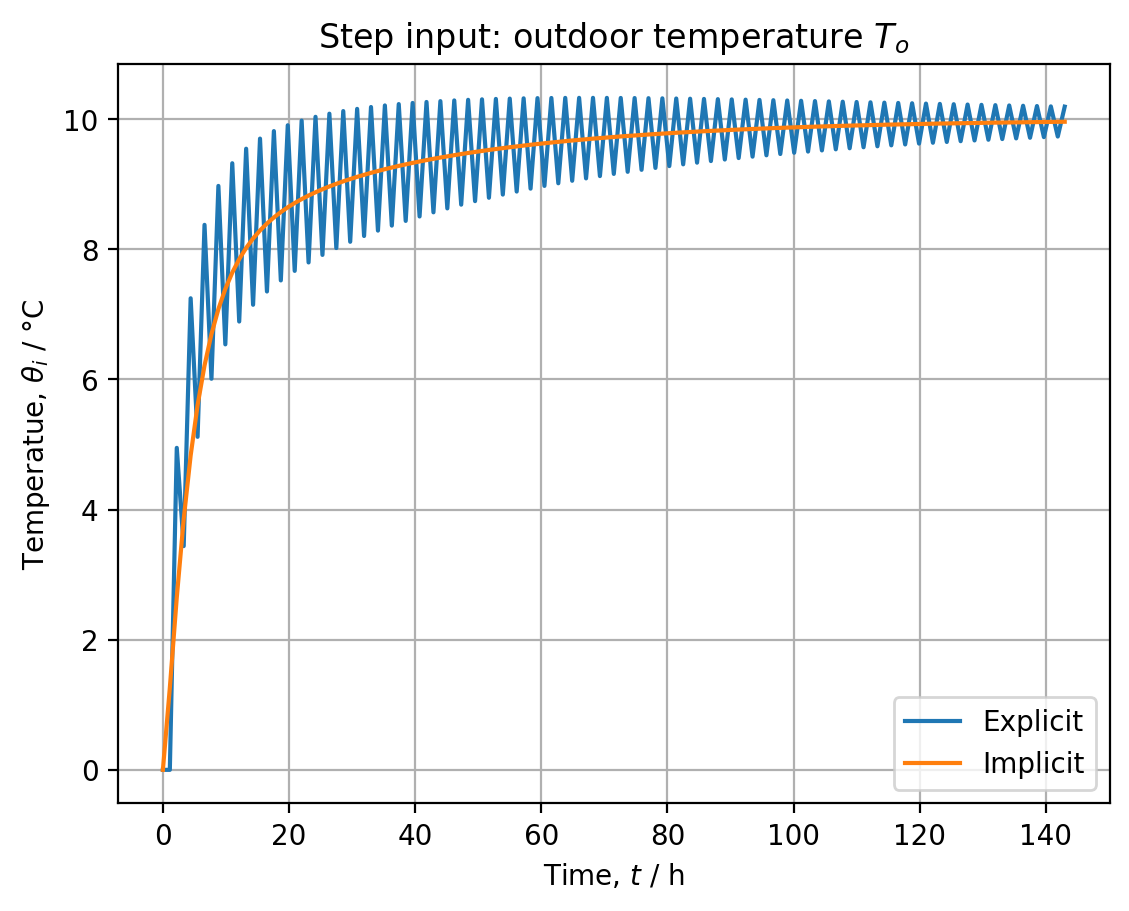

In [37]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()

> Figure 7. Step response to outdoor temperature by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.

The value the indoor temperature obtained after the [settling time](https://en.m.wikipedia.org/wiki/Settling_time) is almost equal to the value obtained in steady-state.

In [38]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 9.7335 °C
